## Imports

In [5]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json
import copy
from plotly.subplots import make_subplots
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
from datetime import datetime
from collections import defaultdict

In [125]:
data = json.load(open('research/output/youtube_data.json'))
channels = json.load(open('research/output/channels.json'))

## Processing

In [126]:
persuasions = ["Social Identity", "Concreteness", "Anchoring and Comparison", "Overcoming Reactance", "Reciprocity",
"Foot in the Door", "Authority", "Social Impact", "Anthropomorphism", "Scarcity", "Social Proof", "Unclear"]
sector_list = {"Technology": "#19A7CE", 
               "Media": "#F24C3D", 
               "Retailing and Apparel": "#F2BE22", 
               "Finance": "#00DFA2", 
               "Food and Household": "#F97B22", 
               "Wholesalers, Industrials and Energy": "#77037B", 
               "Transportation": "#413543",
               "Aerospace and Defence": "#090580",
               "Healthcare": "#FFACAC"}
year_list = ["Before 2014", '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
seasons = ["Spring", "Summer", "Monsoon", "Autumn", "Winter"]

month_to_season = {
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Monsoon",
    "Sep": "Monsoon",
    "Oct": "Monsoon",
    "Nov": "Autumn",
    "Dec": "Winter"
}

In [127]:
frequency = {}
for video, values in data.items():
    for i, strat in enumerate(values["annots"]):
        if strat not in frequency:
            frequency[strat] = {"overall":0}
        frequency[strat]["overall"] += 1

In [128]:
companies = {}
for video, values in data.items():
    company = values["channelTitle"]
    if company not in companies:
        companies[company] = {"count":0, "videos":{}}
    y = values["publishedAt"][0:4]
    if int(y) <= 2013:
        y = "Before 2014"
    companies[company]["count"] += 1
    companies[company]["videos"][video] = {"annots":values["annots"], "publishedIn": y, "likeCount": values["likeCount"], "publishedAt":values["publishedAt"], "publishedIn": y,
                                         "viewCount":values["viewCount"], "sector": values["sector"], "videoTag":"video "+str(companies[company]["count"]), "commentCount":values["commentCount"]}
companies = dict(sorted(companies.items(), key=lambda item: item[0]))

In [129]:
for company in companies:
    companies[company]["subscriberCount"] = channels[company]["subscriberCount"]
    companies[company]["channelViewCount"] = channels[company]["channelViewCount"]    

In [130]:
top_5_companies = sorted(companies.items(), key=lambda x: x[1]["count"], reverse=True)[:5]
top_5_company_names = [company[0] for company in top_5_companies]

In [131]:
df = pd.DataFrame.from_dict(frequency).T

In [132]:
sectors = {}
for sector in sector_list:
    sectors[sector] = {"count":0, "num_companies":0, "videos":{}}

for video, values in data.items():
    sec = values["sector"]
    company = values["channelTitle"]
    for sector in sectors:
        if sec in sector:
            y = values["publishedAt"][0:4]
            if int(y) <= 2013:
                y = "Before 2014"
            sectors[sector]["count"] += 1
            sectors[sector]["videos"][video] = {"annots":values["annots"], "commentCount": values['commentCount'], "channelTitle":company, "publishedIn": y, "publishedAt":values["publishedAt"], "likeCount": values["likeCount"],
                                                 "viewCount":values["viewCount"], "videoTag":"video "+str(companies[company]["count"])}

In [133]:
sector_list_org = {"Technology": {}, "Media": {}, "Retailing": {}, "Apparel": {}, "Finance": {}, "Food": {}, "Household": {}, 
               "Wholesalers": {}, "Industrials": {}, "Energy": {}, "Transportation": {}, "Aerospace and Defence": {}, "Healthcare": {}}
for video, values in data.items():
    sector = values["sector"]
    company = values["channelTitle"]
    if company not in sector_list_org:
        sector_list_org[values["sector"]][company] = 0

for sector in sector_list_org:
    sector_list_org[sector] = len(sector_list_org[sector])

In [134]:
for sector, vals in sectors.items():
    unique_comp = {}
    for _, content in vals["videos"].items():
        unique_comp[content["channelTitle"]] = 0
    vals["num_companies"] = len(unique_comp)

## Company Trends

In [43]:
filtered_companies

{}

In [323]:
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt

all_data = {}
cum_freq = {}

color_cycle = itertools.cycle(px.colors.qualitative.Plotly)

for this_sector in sector_list:
    for this_strategy in persuasions:
        sector_strategy_data = {}

        for company, content in companies.items():
            sector_strategy_data[company] = {"Date": [], "Frequency": [], "Engagement Metric": [], "Outreach Metric": []}
            for video, values in content["videos"].items():
                sector = values.get("sector", "")  # Get the sector for the video
                frequency = 1
                date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ").date()  # Extract date only

                if sector == this_sector and this_strategy in values["annots"]:
                    sector_strategy_data[company]["Date"].append(date)
                    sector_strategy_data[company]["Frequency"].append(frequency)
                    engagement_metric = (values["likeCount"] + values["commentCount"]) / values["viewCount"]
                    outreach_metric = values["viewCount"] / frequency
                    sector_strategy_data[company]["Engagement Metric"].append(engagement_metric)
                    sector_strategy_data[company]["Outreach Metric"].append(outreach_metric)

        sector_strategy_data = {company: data for company, data in sector_strategy_data.items() if any(data.values())}

        metric_figures = {}
        for metric in ['Frequency', 'Engagement Metric', 'Outreach Metric']:
            fig = go.Figure()

            for company, data in sector_strategy_data.items():
                cum_freq[company] = {}
                df = pd.DataFrame(data)
                if not df.empty and "Date" in df.columns:  # Skip companies with no data or missing 'Date' column
                    df["Date"] = pd.to_datetime(df["Date"])  # Ensure "Date" column is in datetime format
                    df.set_index("Date", inplace=True)
                    df = df.resample('M').sum()

                    color = next(color_cycle)  # Get the next distinct color
                    if metric == 'Frequency':
                        fig.add_trace(go.Scatter(x=df.index, y=df[metric].cumsum(), mode="lines", name=company, line=dict(color=color)))
                        cum_freq[company][(this_sector, this_strategy)] = df[metric].cumsum()
                    else:
                        fig.add_trace(go.Scatter(x=df.index, y=df[metric], mode="lines", name=company, line=dict(color=color)))

            # Update the layout and labels as needed for each metric
            fig.update_layout(
                xaxis_title="Date",
                yaxis_title=f"{metric} Value",
                title=f"{this_strategy} {metric} for {this_sector}",
            )

            metric_figures[metric] = fig

        # Store the figures for the sector and strategy combination
        all_data[(this_sector, this_strategy)] = metric_figures

In [198]:
print(sector_list)

{'Technology': '#19A7CE', 'Media': '#F24C3D', 'Retailing and Apparel': '#F2BE22', 'Finance': '#00DFA2', 'Food and Household': '#F97B22', 'Wholesalers, Industrials and Energy': '#77037B', 'Transportation': '#413543', 'Aerospace and Defence': '#090580', 'Healthcare': '#FFACAC'}


In [324]:
print(cum_freq)

{'AT&T': {}, 'Adobe Creative Cloud': {}, 'Apple': {}, 'Cisco': {}, 'Facebook': {}, 'Intuit': {}, 'MicronTechnology': {}, 'Microsoft': {}, 'Motorola': {}, 'NVIDIA': {}, 'Qualcomm': {}, 'Salesforce': {}, 'Thermo Fisher Scientific': {}, 'Uber': {}, 'WD': {}, 'Xerox': {}, 'ebay': {}, 'Blizzard Entertainment': {}, 'CACI International Inc': {}, 'Cognizant': {}, 'CommScope': {}, 'IBM': {}, 'NCR Corporation': {}, 'Texas Instruments': {}, 'Netflix': {}, 'Viacom18 Studios': {}, 'Walt Disney Studios': {}, 'Allstate': {}, 'Ally': {}, 'American Express': {}, 'Capital One': {}, 'Discover': {}, 'Farmers Insurance': {}, 'Fifth Third Bank': {}, 'Liberty Mutual': {}, 'MassMutual': {}, 'Mutual of Omaha': {}, 'New York Life Insurance Company': {}, 'Northwestern Mutual': {}, 'Pacific Life': {}, 'Prudential': {}, 'Square': {}, 'State Farm Insurance': {}, 'Synchrony': {}, 'T. Rowe Price': {}, 'The Hartford': {}, 'Wells Fargo': {}, 'jpmorgan': {}, 'Regions Bank': {}, 'Voya Financial': {}, 'Autoliv': {}, 'FedE

#### General

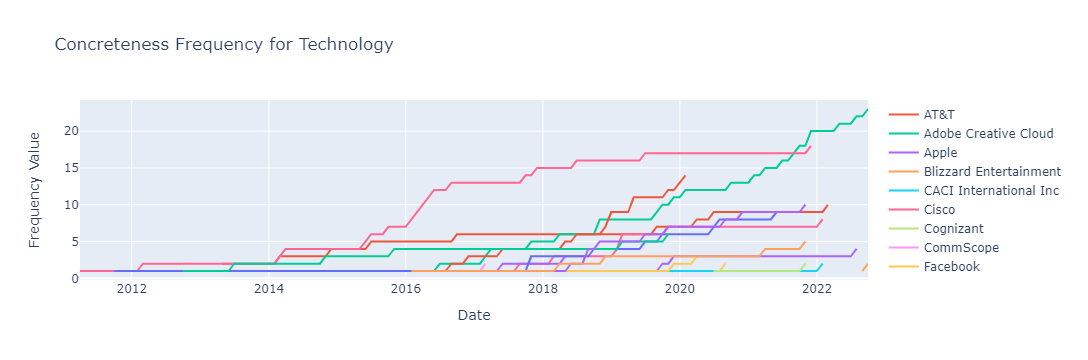

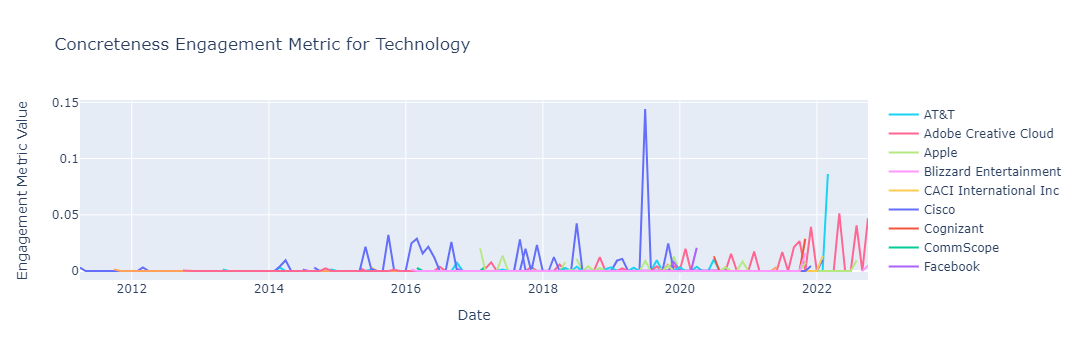

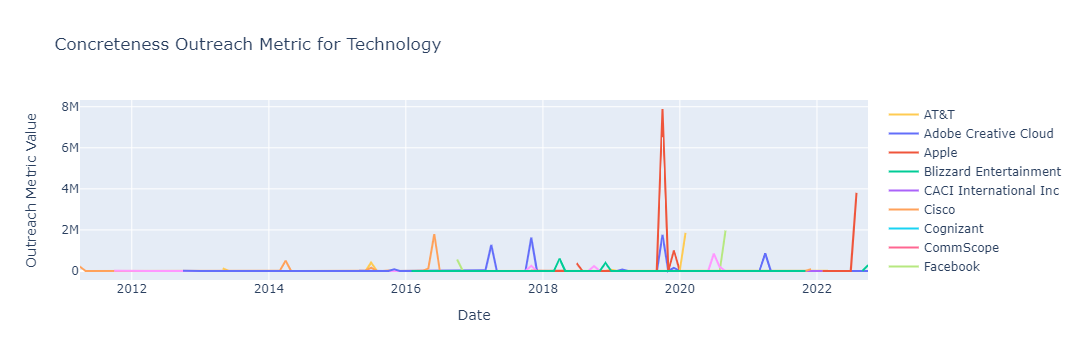

In [325]:
sec = 'Technology'
per = 'Concreteness'
for metric, fig in all_data[(sec, per)].items():
    fig.show()

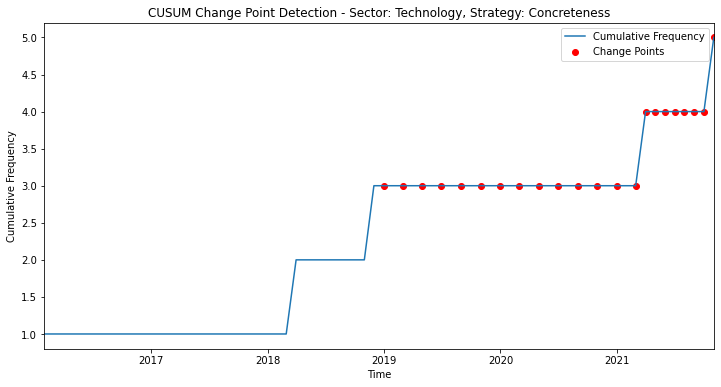

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'cum_freq' is a dictionary containing cumulative frequency time series for different sectors and strategies
# For example: cum_freq = {('Technology', 'Concreteness'): pd.Series([...]), ...}

def cusum_detection(time_series, threshold=1.0):
    mean_value = time_series.mean()
    cumulative_sum = 0
    change_points = []

    for i, value in enumerate(time_series):
        cumulative_sum = max(0, cumulative_sum + (value - mean_value))
        if cumulative_sum > threshold:
            change_points.append(i)
            cumulative_sum = 0

    return change_points

# Example usage:
this_sector = 'Technology'
this_strategy = 'Concreteness'
cumulative_frequency_series = cum_freq[(this_sector, this_strategy)]

# Detect change points using CUSUM
change_points = cusum_detection(cumulative_frequency_series, threshold=1.0)

# Plot the time series with detected change points
plt.figure(figsize=(12, 6))
plt.plot(cumulative_frequency_series.index, cumulative_frequency_series, label='Cumulative Frequency')
plt.scatter(cumulative_frequency_series.index[change_points], cumulative_frequency_series.iloc[change_points], color='red', label='Change Points')
plt.title(f"CUSUM Change Point Detection - Sector: {this_sector}, Strategy: {this_strategy}")
plt.xlabel('Time')
plt.ylabel('Cumulative Frequency')

# Set the x-axis range based on the first and last dates in the time series
plt.xlim(cumulative_frequency_series.index[0], cumulative_frequency_series.index[-1])

plt.legend()
plt.show()

In [266]:
# Initialize a dictionary to track strategies used by each company within each sector
company_strategies = {(company, sector): {"strategies": set(), "videos": []} for company in companies for video, values in companies[company]["videos"].items() for sector in sectors}

# Iterate through each company's videos
for company, content in companies.items():
    for video, values in content["videos"].items():
        sector = values["sector"]
        strats = values["annots"]
        views = values["viewCount"]
        subscribers = companies[company]["subscriberCount"]
        viewsBySubscribers = views / subscribers
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")

        # Track the strategies used by the company within the specific sector
        company_strategies[(company, sector)]["strategies"].update(strats)
        company_strategies[(company, sector)]["videos"].append({
            "viewsBySubscribers": viewsBySubscribers,
            "strategies": strats
        })

# Identify companies that use similar strategies within each sector
for (company, sector), data in company_strategies.items():
    used_strategies = data["strategies"]
    videos = data["videos"]

    for (other_company, other_sector), other_data in company_strategies.items():
        if (other_company != company) and (other_sector == sector):
            other_used_strategies = other_data["strategies"]
            common_strategies = used_strategies.intersection(other_used_strategies)

            # If common strategies exist, consider the other company as a follower
            if common_strategies:
                for common_strategy in common_strategies:
                    follower_videos = [video for video in other_data["videos"] if common_strategy in video["strategies"]]
                    leader_videos = [video for video in videos if common_strategy in video["strategies"]]

                    # Filter out relationships based on conditions
                    if (
                        len(leader_videos) >= 2  # At least two videos for the leader
                        and len(follower_videos) >= 1  # At least one video for the follower
                        and sum(video["viewsBySubscribers"] for video in leader_videos) > sum(video["viewsBySubscribers"] for video in follower_videos)  # Leader has more total views
                        and all(video["viewsBySubscribers"] >= 2 for video in leader_videos)  # Each video by the leader has at least 2 viewsBySubscribers
                        and all(video["viewsBySubscribers"] >= 1 for video in follower_videos)  # Each video by the follower has at least 1 viewsBySubscribers
                    ):
                        print(f"{company} (Leader) -> {other_company} (Follower) for strategy '{common_strategy}' in sector '{sector}'")

BD (Leader) -> Republic Services (Follower) for strategy 'Concreteness' in sector 'Healthcare'
BD (Leader) -> Tenet Health Central Coast (Follower) for strategy 'Concreteness' in sector 'Healthcare'
Big Lots (Leader) -> Lithia Motors, Inc (Follower) for strategy 'Overcoming Reactance' in sector 'Retailing'
Big Lots (Leader) -> Lithia Motors, Inc (Follower) for strategy 'Foot in the Door' in sector 'Retailing'
DICK'S Sporting Goods (Leader) -> Advance Auto Parts (Follower) for strategy 'Social Impact' in sector 'Retailing'
DICK'S Sporting Goods (Leader) -> Casey's (Follower) for strategy 'Social Impact' in sector 'Retailing'
FirstEnergy (Leader) -> Entergy (Follower) for strategy 'Unclear' in sector 'Energy'
Graybar (Leader) -> US Foods (Follower) for strategy 'Social Identity' in sector 'Wholesalers'
Lithia Motors, Inc (Leader) -> Big Lots (Follower) for strategy 'Anchoring and Comparison' in sector 'Retailing'
Lithia Motors, Inc (Leader) -> Casey's (Follower) for strategy 'Concretenes

In [252]:
import plotly.express as px
import pandas as pd
from collections import Counter
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Your existing data and month_order remain the same

# Create a dictionary of DataFrames by sector
sectors = set()
fig_dict = {}
dataframes_by_sector = {}

for company, content in companies.items():
    for video, values in content["videos"].items():
        sector = values["sector"]
        sectors.add(sector)

for sector in sectors:
    strategies_data = {strat: {"leader": 0, "follower": 0} for strat in persuasions}

    for company, content in companies.items():
        for video, values in content["videos"].items():
            strats = values["annots"]
            views = values["viewCount"]
            subscribers = companies[company]["subscriberCount"]
            viewsBySubscribers = views / subscribers
            video_sector = values["sector"]
            date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")

            if video_sector == sector:
                for strat in strats:
                    strategies_data[strat]["leader"] += viewsBySubscribers

    # Get the top strategies with the most views for the current sector
    top_strategies = [strat for strat, data in strategies_data.items() if data["leader"] > 0]

    # Initialize a new data structure for top strategies
    top_strategies_data = {strat: {"leader": [], "follower": []} for strat in top_strategies}

    for company, content in companies.items():
        for video, values in content["videos"].items():
            strats = values["annots"]
            views = values["viewCount"]
            video_sector = values["sector"]
            subscribers = companies[company]["subscriberCount"]
            date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")

            if video_sector == sector:
                for strat in strats:
                    if strat in top_strategies:
                        if viewsBySubscribers >= strategies_data[strat]["leader"]:
                            top_strategies_data[strat]["leader"].append({"Company": company, "Date": date, "ViewsBySubscribers": viewsBySubscribers})
                        else:
                            top_strategies_data[strat]["follower"].append({"Company": company, "Date": date, "ViewsBySubscribers": viewsBySubscribers})

In [253]:
strategies_data

{'Social Identity': {'leader': 1805.7974489274027, 'follower': 0},
 'Concreteness': {'leader': 1607.8331406152843, 'follower': 0},
 'Anchoring and Comparison': {'leader': 432.98659128397725, 'follower': 0},
 'Overcoming Reactance': {'leader': 1562.9679467517556, 'follower': 0},
 'Reciprocity': {'leader': 1651.3529655286036, 'follower': 0},
 'Foot in the Door': {'leader': 1532.0468206112243, 'follower': 0},
 'Authority': {'leader': 355.36353703734835, 'follower': 0},
 'Social Impact': {'leader': 284.5774512458055, 'follower': 0},
 'Anthropomorphism': {'leader': 407.4219334940513, 'follower': 0},
 'Scarcity': {'leader': 180.07070596044758, 'follower': 0},
 'Social Proof': {'leader': 85.37613325190851, 'follower': 0},
 'Unclear': {'leader': 542.2276795576224, 'follower': 0}}

In [254]:
import pandas as pd
from datetime import datetime

# Initialize a dictionary to track strategies used by each company within each sector
company_strategies = {(company, sector): {"strategies": set(), "videos": []} for company in companies for video, values in companies[company]["videos"].items() for sector in sectors}

# Initialize dictionaries to store leader and follower information for each sector
leaders_by_sector = {sector: {"Company": [], "Date": [], "Strategy": []} for sector in sectors}
followers_by_sector = {sector: {"LeaderCompany": [], "FollowerCompany": [], "Date": [], "Strategy": []} for sector in sectors}

# Iterate through each company's videos
for company, content in companies.items():
    for video, values in content["videos"].items():
        sector = values["sector"]
        strats = values["annots"]
        views = values["viewCount"]
        subscribers = companies[company]["subscriberCount"]
        viewsBySubscribers = views / subscribers
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")

        # Track the strategies used by the company within the specific sector
        company_strategies[(company, sector)]["strategies"].update(strats)
        company_strategies[(company, sector)]["videos"].append({
            "date": date,
            "viewsBySubscribers": viewsBySubscribers,
            "strategies": strats
        })

# Identify companies that use similar strategies within each sector
for (company, sector), data in company_strategies.items():
    used_strategies = data["strategies"]
    videos = data["videos"]

    for (other_company, other_sector), other_data in company_strategies.items():
        if (other_company != company) and (other_sector == sector):
            other_used_strategies = other_data["strategies"]
            common_strategies = used_strategies.intersection(other_used_strategies)

            # If common strategies exist, consider the other company as a follower
            if common_strategies:
                for common_strategy in common_strategies:
                    follower_videos = [video for video in other_data["videos"] if common_strategy in video["strategies"]]
                    leader_videos = [video for video in videos if common_strategy in video["strategies"]]

                    # Find the trigger video for both leader and follower
                    trigger_leader_video = min(leader_videos, key=lambda x: x["date"]) if leader_videos else None
                    trigger_follower_video = min(follower_videos, key=lambda x: x["date"]) if follower_videos else None

                    # Filter out relationships based on conditions
                    if (
                        trigger_leader_video  # Leader has a trigger video
                        and trigger_follower_video  # Follower has a trigger video
                        and trigger_leader_video["date"] < trigger_follower_video["date"]  # Trigger video of leader released before trigger video of follower
                        and trigger_leader_video["viewsBySubscribers"] > trigger_follower_video["viewsBySubscribers"]  # Leader's trigger video has more views per subscriber
                    ):
                        # Store leader information in the leaders_by_sector dictionary
                        leaders_by_sector[sector]["Company"].append(company)
                        leaders_by_sector[sector]["Date"].append(trigger_leader_video["date"])
                        leaders_by_sector[sector]["Strategy"].append(common_strategy)

                        # Store follower information in the followers_by_sector dictionary
                        followers_by_sector[sector]["LeaderCompany"].append(company)
                        followers_by_sector[sector]["FollowerCompany"].append(other_company)
                        followers_by_sector[sector]["Date"].append(trigger_follower_video["date"])
                        followers_by_sector[sector]["Strategy"].append(common_strategy)

# Convert dictionaries to DataFrames
leaders_df_by_sector = {sector: pd.DataFrame(data) for sector, data in leaders_by_sector.items()}
followers_df_by_sector = {sector: pd.DataFrame(data) for sector, data in followers_by_sector.items()}

In [256]:
followers_df_by_sector['Technology']

LeaderCompany       FollowerCompany                Date  \
0            AT&T  Adobe Creative Cloud 2015-04-09 03:58:03   
1            AT&T  Adobe Creative Cloud 2015-04-09 03:58:03   
2            AT&T  Adobe Creative Cloud 2016-06-21 13:55:40   
3            AT&T  Adobe Creative Cloud 2018-03-06 17:00:00   
4            AT&T  Adobe Creative Cloud 2016-06-21 13:55:40   
..            ...                   ...                 ...   
613          ebay                  Uber 2016-08-17 21:41:07   
614          ebay                  Uber 2016-07-12 18:23:03   
615          ebay                  Uber 2016-07-12 18:23:03   
616          ebay                  Uber 2016-07-12 18:23:03   
617          ebay                 Xerox 2018-10-19 18:05:34   

                 Strategy  
0    Overcoming Reactance  
1             Reciprocity  
2               Authority  
3        Anthropomorphism  
4         Social Identity  
..                    ...  
613  Overcoming Reactance  
614       Social Identity  
615          Concreteness  
616      Foot in the Door  
617             Authority  

[618 rows x 4 columns]

In [261]:
import pandas as pd
from datetime import datetime

def find_peak_videos(company_videos):
    """
    Given a dictionary of videos for a company, find the peak/viral videos and return them as trigger videos.
    """
    # Find top N videos based on viewsBySubscribers
    top_videos = sorted(company_videos, key=lambda x: x["viewsBySubscribers"], reverse=True)[:2]

    # Find the video with the maximum viewsBySubscribers
    peak_video = max(company_videos, key=lambda x: x["viewsBySubscribers"], default=None)

    return peak_video

# Initialize a dictionary to track strategies used by each company within each sector
company_strategies = {(company, sector): {"strategies": set(), "videos": []} for company in companies for video, values in companies[company]["videos"].items() for sector in sectors}

# Initialize dictionaries to store leader and follower information for each sector
leaders_by_sector = {sector: {"Company": [], "Date": [], "Strategy": []} for sector in sectors}
followers_by_sector = {sector: {"LeaderCompany": [], "FollowerCompany": [], "Date": [], "Strategy": []} for sector in sectors}

# Iterate through each company's videos
for company, content in companies.items():
    for video, values in content["videos"].items():
        sector = values["sector"]
        strats = values["annots"]
        views = values["viewCount"]
        subscribers = companies[company]["subscriberCount"]
        viewsBySubscribers = views / subscribers
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")

        # Track the strategies used by the company within the specific sector
        company_strategies[(company, sector)]["strategies"].update(strats)
        company_strategies[(company, sector)]["videos"].append({
            "date": date,
            "viewsBySubscribers": viewsBySubscribers,
            "strategies": strats
        })

# Identify companies that use similar strategies within each sector
for (company, sector), data in company_strategies.items():
    used_strategies = data["strategies"]
    videos = data["videos"]

    for (other_company, other_sector), other_data in company_strategies.items():
        if (other_company != company) and (other_sector == sector):
            other_used_strategies = other_data["strategies"]
            common_strategies = used_strategies.intersection(other_used_strategies)

            # If common strategies exist, consider the other company as a follower
            if common_strategies:
                for common_strategy in common_strategies:
                    follower_videos = [video for video in other_data["videos"] if common_strategy in video["strategies"]]
                    leader_videos = [video for video in videos if common_strategy in video["strategies"]]

                    # Find the trigger video for both leader and follower
                    trigger_leader_video = find_peak_videos(leader_videos)
                    trigger_follower_video = find_peak_videos(follower_videos)

                    # Filter out relationships based on conditions
                    if (
                        trigger_leader_video  # Leader has a trigger video
                        and trigger_follower_video  # Follower has a trigger video
                        and trigger_leader_video["date"] < trigger_follower_video["date"]  # Trigger video of leader released before trigger video of follower
                        and trigger_leader_video["viewsBySubscribers"] > trigger_follower_video["viewsBySubscribers"]  # Leader's trigger video has more views per subscriber
                    ):
                        # Store leader information in the leaders_by_sector dictionary
                        leaders_by_sector[sector]["Company"].append(company)
                        leaders_by_sector[sector]["Date"].append(trigger_leader_video["date"])
                        leaders_by_sector[sector]["Strategy"].append(common_strategy)

                        # Store follower information in the followers_by_sector dictionary
                        followers_by_sector[sector]["LeaderCompany"].append(other_company)
                        followers_by_sector[sector]["FollowerCompany"].append(company)  # Swap leader and follower for the follower dictionary
                        followers_by_sector[sector]["Date"].append(trigger_follower_video["date"])
                        followers_by_sector[sector]["Strategy"].append(common_strategy)

# Convert dictionaries to DataFrames
leaders_df_by_sector = {sector: pd.DataFrame(data) for sector, data in leaders_by_sector.items()}
followers_df_by_sector = {sector: pd.DataFrame(data) for sector, data in followers_by_sector.items()}


In [248]:
strategies_data = {}

for company, content in companies.items():
    strategies_data[company] = {(year, month): {} for year in range(2009, 2023) for month in month_order}
    for video, values in content["videos"].items():
        strats = values["annots"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        video_month = date.strftime("%b")
        video_year = date.year

        if video_month in month_order:
            for strat in strats:
                if strat not in strategies_data[company][(video_year, video_month)]:
                    strategies_data[company][(video_year, video_month)][strat] = 0
                strategies_data[company][(video_year, video_month)][strat] += 1


In [251]:
strategies_data['Adobe Creative Cloud']

{(2009, 'Jan'): {},
 (2009, 'Feb'): {},
 (2009, 'Mar'): {},
 (2009, 'Apr'): {},
 (2009, 'May'): {},
 (2009, 'Jun'): {},
 (2009, 'Jul'): {},
 (2009, 'Aug'): {},
 (2009, 'Sep'): {},
 (2009, 'Oct'): {},
 (2009, 'Nov'): {},
 (2009, 'Dec'): {},
 (2010, 'Jan'): {},
 (2010, 'Feb'): {},
 (2010, 'Mar'): {},
 (2010, 'Apr'): {},
 (2010, 'May'): {},
 (2010, 'Jun'): {},
 (2010, 'Jul'): {},
 (2010, 'Aug'): {},
 (2010, 'Sep'): {},
 (2010, 'Oct'): {},
 (2010, 'Nov'): {},
 (2010, 'Dec'): {},
 (2011, 'Jan'): {},
 (2011, 'Feb'): {},
 (2011, 'Mar'): {},
 (2011, 'Apr'): {},
 (2011, 'May'): {},
 (2011, 'Jun'): {},
 (2011, 'Jul'): {},
 (2011, 'Aug'): {},
 (2011, 'Sep'): {},
 (2011, 'Oct'): {},
 (2011, 'Nov'): {},
 (2011, 'Dec'): {},
 (2012, 'Jan'): {},
 (2012, 'Feb'): {},
 (2012, 'Mar'): {},
 (2012, 'Apr'): {},
 (2012, 'May'): {},
 (2012, 'Jun'): {},
 (2012, 'Jul'): {},
 (2012, 'Aug'): {},
 (2012, 'Sep'): {},
 (2012, 'Oct'): {},
 (2012, 'Nov'): {},
 (2012, 'Dec'): {},
 (2013, 'Jan'): {},
 (2013, 'Feb'): {},


In [ ]:
import pandas as pd
from datetime import datetime

# Function to find peak videos for a given list of videos
def find_peak_videos(videos):
    return sorted(videos, key=lambda x: x.get("viewsBySubscribers", 0), reverse=True)[:2]

# Initialize a dictionary to track strategies used by each company within each sector
company_strategies = {(company, sector): {"strategies": set(), "videos": [], "strategy_frequency": {}, "trigger_date": None} for company in companies for video, values in companies[company]["videos"].items() for sector in sectors}

# Initialize dictionaries to store leader and follower information for each sector
leaders_by_sector = {sector: {"Company": [], "Date": [], "Strategy": []} for sector in sectors}
followers_by_sector = {sector: {"LeaderCompany": [], "FollowerCompany": [], "Date": [], "Strategy": []} for sector in sectors}

# Iterate through each sector and company to identify leader-follower pairs
for sector in sectors:
    companies_in_sector = [company for company, _ in company_strategies.keys() if _ == sector]
    
    # Nested loop over all companies in the sector
    for leader_company in companies_in_sector:
        for follower_company in companies_in_sector:
            if leader_company != follower_company:
                leader_data = company_strategies[(leader_company, sector)]
                follower_data = company_strategies[(follower_company, sector)]
                
                # Get the date of the trigger video for the leader
                leader_trigger_date = None
                leader_peak_videos = leader_data.get("peak_videos", [])
                if leader_peak_videos:
                    leader_trigger_date = leader_peak_videos[0]["date"]
                
                # Store the date of the trigger video
                follower_data["trigger_date"] = None
                
                # Store the strategy frequencies before the trigger for the follower company
                follower_data["strategy_frequency"] = {strategy: 0 for strategy in leader_data["strategies"]}
                
                # Identify common strategies
                common_strategies = set(leader_data["strategies"]).intersection(follower_data["strategies"])
                
                # Check for a significant change in strategy frequency
                significant_change = any(
                    follower_data["strategy_frequency"].get(strategy, 0) > 0
                    for strategy in common_strategies
                )
                
                # If there is a significant change, form a leader-follower pair
                if significant_change:
                    leaders_by_sector[sector]["Company"].append(leader_company)
                    leaders_by_sector[sector]["Date"].append(leader_trigger_date)
                    leaders_by_sector[sector]["Strategy"].append(common_strategies.pop())
                    
                    followers_by_sector[sector]["LeaderCompany"].append(leader_company)
                    followers_by_sector[sector]["FollowerCompany"].append(follower_company)
                    followers_by_sector[sector]["Date"].append(follower_data["trigger_date"])
                    followers_by_sector[sector]["Strategy"].append(common_strategies.pop())

# Convert dictionaries to DataFrames
leaders_df_by_sector = {sector: pd.DataFrame(data) for sector, data in leaders_by_sector.items()}
followers_df_by_sector = {sector: pd.DataFrame(data) for sector, data in followers_by_sector.items()}


In [232]:
# leaders_df_by_sector['Technology']
followers_df_by_sector['Technology']

LeaderCompany FollowerCompany                Date  \
0        Adobe Creative Cloud            AT&T 2017-10-02 13:00:03   
1        Adobe Creative Cloud            AT&T 2016-06-21 13:55:40   
2        Adobe Creative Cloud            AT&T 2018-03-06 17:00:00   
3        Adobe Creative Cloud            AT&T 2019-09-27 23:21:57   
4        Adobe Creative Cloud            AT&T 2019-09-27 23:21:57   
..                        ...             ...                 ...   
616         Texas Instruments            ebay 2019-11-04 19:45:05   
617  Thermo Fisher Scientific            ebay 2018-09-05 21:46:30   
618                      Uber            ebay 2020-01-23 23:59:53   
619                     Xerox            ebay 2018-10-19 18:05:34   
620                     Xerox            ebay 2018-10-19 18:05:34   

                 Strategy  
0    Overcoming Reactance  
1               Authority  
2        Anthropomorphism  
3         Social Identity  
4            Concreteness  
..                    ...  
616          Concreteness  
617             Authority  
618          Concreteness  
619             Authority  
620       Social Identity  

[621 rows x 4 columns]

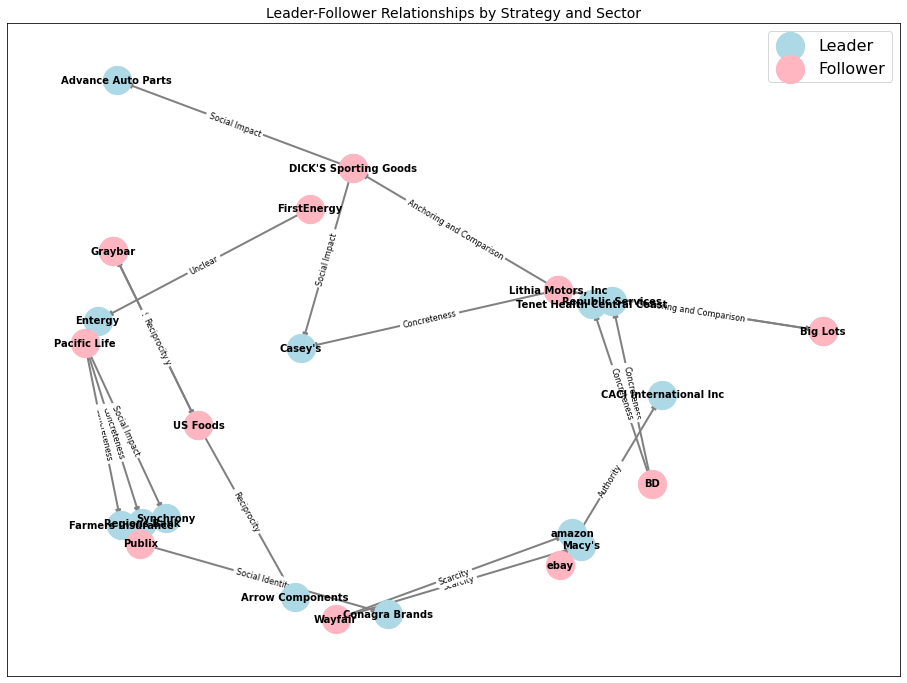

In [228]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a directed graph to represent leader-follower relationships
G = nx.DiGraph()

# Identify companies that use similar strategies within each sector
for (company, sector), data in company_strategies.items():
    used_strategies = data["strategies"]
    videos = data["videos"]

    for (other_company, other_sector), other_data in company_strategies.items():
        if (other_company != company) and (other_sector == sector):
            other_used_strategies = other_data["strategies"]
            common_strategies = used_strategies.intersection(other_used_strategies)

            # If common strategies exist, consider the other company as a follower
            if common_strategies:
                for common_strategy in common_strategies:
                    follower_videos = [video for video in other_data["videos"] if common_strategy in video["strategies"]]
                    leader_videos = [video for video in videos if common_strategy in video["strategies"]]

                    # Filter out relationships based on conditions
                    if (
                        len(leader_videos) >= 2  # At least two videos for the leader
                        and len(follower_videos) >= 1  # At least one video for the follower
                        and sum(video["viewsBySubscribers"] for video in leader_videos) > sum(video["viewsBySubscribers"] for video in follower_videos)  # Leader has more total views
                        and all(video["viewsBySubscribers"] >= 2 for video in leader_videos)  # Each video by the leader has at least 2 viewsBySubscribers
                        and all(video["viewsBySubscribers"] >= 1 for video in follower_videos)  # Each video by the follower has at least 1 viewsBySubscribers
                    ):
                        G.add_edge(company, other_company, strategy=common_strategy, relationship="Leader-Follower")

# Visualize the network plot
plt.figure(figsize=(16, 12))

# Use Kamada-Kawai layout and adjust spacing
pos = nx.kamada_kawai_layout(G, scale=2.0)

labels = nx.get_edge_attributes(G, 'strategy')
relationship_labels = nx.get_edge_attributes(G, 'relationship')

leaders = [node for node, degree in G.in_degree() if degree > 0]
followers = [node for node, degree in G.out_degree() if degree > 0]

nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    font_size=10,
    node_size=400,
    node_color='lightblue',  # Default color for nodes
    font_color='black',
    font_weight='bold',
    edge_color='gray',  # Change the edge color
    width=2.0,  # Change the edge width
)

# Assign different colors to leaders and followers
nx.draw_networkx_nodes(G, pos, nodelist=leaders, node_color='lightblue', node_size=800, label='Leader')
nx.draw_networkx_nodes(G, pos, nodelist=followers, node_color='lightpink', node_size=800, label='Follower')

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=labels,
    font_color='black',
    font_size=8,
)

# Add a legend
legend = plt.legend(loc='upper right')
legend.set_title("Node Type")
plt.legend(prop={'size': 16})

plt.title("Leader-Follower Relationships by Strategy and Sector", fontsize=14)
plt.show()

In [113]:
features_scaled

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [95]:
print(len(standardized_data_subset))

925


In [76]:
dataframes_by_sector["Technology"].describe

<bound method NDFrame.describe of                   Date  ViewsBySubscribers
0  2016-09-10 17:34:53            0.020034
1  2013-04-26 11:24:16            0.020034
2  2019-08-07 16:14:00            0.020034
3  2014-02-05 15:48:43            0.020034
4  2013-04-26 11:24:16            0.020034
..                 ...                 ...
79 2016-01-12 23:18:25            0.020034
80 2021-03-26 23:35:43            0.020034
81 2016-07-19 00:03:31            0.020034
82 2016-07-18 23:49:24            0.020034
83 2018-03-13 04:02:51            0.020034

[404 rows x 2 columns]>

#### Company

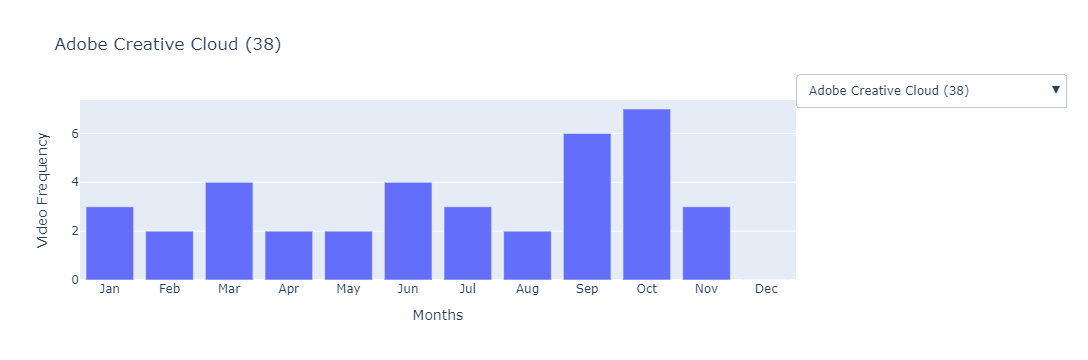

In [27]:
import plotly.graph_objs as go
from datetime import datetime

# Initialize variables for four figures
bar_graphs_likes = []
bar_graphs_views = []
bar_graphs_comments = []
bar_graphs_frequency = []
all_companies = {}

num_companies = len(companies)
plot_dicts = []

j = 0  # Initialize j here

for company, content in companies.items():
    company_likes = [0] * len(months)
    company_views = [0] * len(months)
    company_comments = [0] * len(months)
    video_frequency = [0] * len(months)
    all_companies[company] = {}

    for video, values in content["videos"].items():
        likes = values["likeCount"]
        views = values["viewCount"]
        comments = values["commentCount"]
        date = values["publishedAt"]
        month = datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").month

        company_likes[month - 1] += likes
        company_views[month - 1] += views
        company_comments[month - 1] += comments
        video_frequency[month - 1] += 1
        
    all_companies[company]['likes'] = company_likes
    all_companies[company]['views'] = company_views
    all_companies[company]['comments'] = company_comments
    all_companies[company]['frequency'] = video_frequency

    if j == 0:
        visible_action = True
    else:
        visible_action = False

    trace_likes = go.Bar(
        x=months,
        y=company_likes,
        name=company,
        visible=visible_action,
    )
    bar_graphs_likes.append(trace_likes)

    trace_views = go.Bar(
        x=months,
        y=company_views,
        name=company,
        visible=visible_action,
    )
    bar_graphs_views.append(trace_views)

    trace_comments = go.Bar(
        x=months,
        y=company_comments,
        name=company,
        visible=visible_action,
    )
    bar_graphs_comments.append(trace_comments)
    
    trace_frequency = go.Bar(
        x=months,
        y=video_frequency,
        name=company,
        visible=visible_action,
    )
    bar_graphs_frequency.append(trace_frequency)

    visibility = [False] * num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}],
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j += 1

# Create figures
fig_likes = go.Figure(data=bar_graphs_likes)
fig_likes.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Likes'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig_views = go.Figure(data=bar_graphs_views)
fig_views.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Views'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig_comments = go.Figure(data=bar_graphs_comments)
fig_comments.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Comments'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig_frequency = go.Figure(data=bar_graphs_frequency)
fig_frequency.update_layout(
    barmode='group',
    xaxis=dict(title='Months'),
    yaxis=dict(title='Video Frequency'),
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

In [29]:
print(all_companies['Apple'])

{'likes': [0, 7185, 0, 0, 0, 3919, 35813, 0, 24700, 69173, 12899, 0], 'views': [0, 557873, 0, 0, 0, 368971, 3805008, 0, 8314971, 3172970, 1002615, 0], 'comments': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'frequency': [0, 1, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0]}


In [35]:
all_companies_df = pd.DataFrame.from_dict(all_companies, orient ='index')

In [36]:
all_companies_df.head()

likes  \
3M                                    [0, 0, 0, 0, 92, 0, 0, 45, 0, 4, 0, 0]   
AT&T                          [0, 1318, 98, 82, 9, 500, 0, 39, 20, 0, 54, 0]   
Abbott                             [28, 0, 0, 0, 0, 233, 0, 0, 103, 0, 0, 0]   
Academy Sports + Outdoors              [0, 0, 0, 0, 0, 0, 32, 0, 0, 0, 0, 6]   
Adobe Creative Cloud       [190, 202, 10315, 167, 746, 198, 126, 84, 354,...   

                                                                       views  \
3M                         [0, 0, 0, 0, 20029, 0, 0, 1315218, 0, 3162, 0, 0]   
AT&T                       [0, 64257, 26734, 131115, 4542, 411384, 0, 418...   
Abbott                       [3070, 0, 0, 0, 0, 69322, 0, 0, 59427, 0, 0, 0]   
Academy Sports + Outdoors       [0, 0, 0, 0, 0, 0, 567227, 0, 0, 0, 0, 1144]   
Adobe Creative Cloud       [14819, 123812, 2200608, 10752, 46784, 34147, ...   

                                                               comments  \
3M                                [0, 0, 0, 0, 13, 0, 0, 1, 0, 0, 0, 0]   
AT&T                            [0, 25, 4, 5, 0, 96, 0, 1, 0, 0, 14, 0]   
Abbott                            [0, 0, 0, 0, 0, 85, 0, 0, 1, 0, 0, 0]   
Academy Sports + Outdoors          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]   
Adobe Creative Cloud       [8, 18, 150, 1, 22, 13, 4, 3, 27, 64, 37, 0]   

                                                      frequency  
3M                         [0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0]  
AT&T                       [0, 3, 1, 2, 1, 2, 0, 1, 2, 0, 2, 0]  
Abbott                     [1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0]  
Academy Sports + Outdoors  [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1]  
Adobe Creative Cloud       [3, 2, 4, 2, 2, 4, 3, 2, 6, 7, 3, 0]

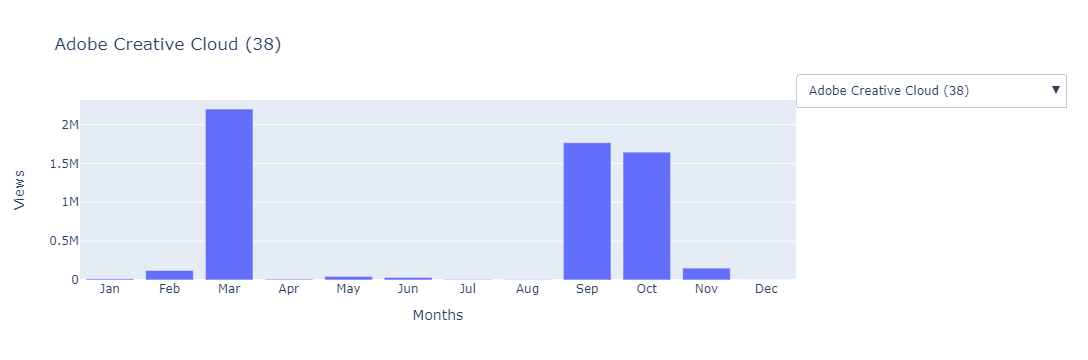

In [59]:
fig_views

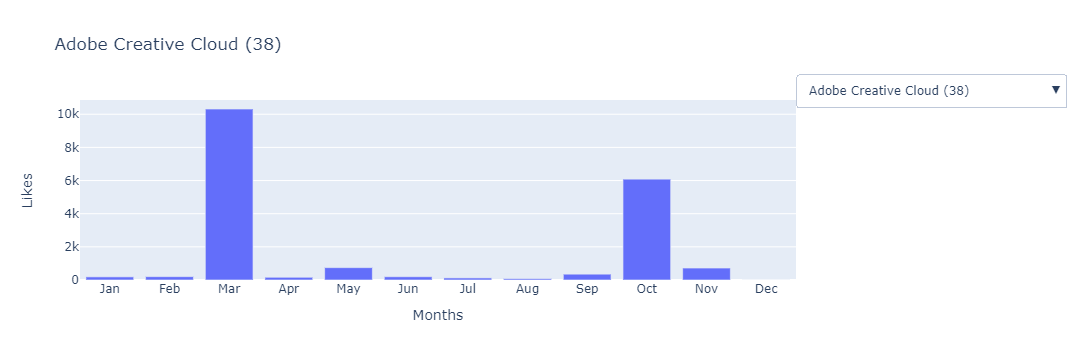

In [60]:
fig_likes

In [233]:
strategies_data = {}
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for company, content in companies.items():
    strategies_data[company] = {month: {} for month in month_order}
    for month in month_order:
        for video, values in content["videos"].items():
            strats = values["annots"]
            date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
            video_month = date.strftime("%b")
            
            if video_month == month:
                for strat in strats:
                    if strat not in strategies_data[company][month]:
                        strategies_data[company][month][strat] = 0
                    strategies_data[company][month][strat] += 1

In [90]:
len_strategies_data = {}

for company, months_data in strategies_data.items():
    len_strategies_data[company] = {}
    for month, strategies in months_data.items():
        len_strategies_data[company][month] = len(strategies.values())

In [91]:
strategies_data = {}
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for company, content in companies.items():
    strategies_data[company] = {}
    for video, values in content["videos"].items():
        strats = values["annots"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        month = date.strftime("%b")

        for strat in strats:
            if strat not in strategies_data[company]:
                strategies_data[company][strat] = {month: 0 for month in month_order}
            strategies_data[company][strat][month] += 1

In [92]:
print(list(len_strategies_data['Netflix'].values()))
for metric in all_companies[company]:
    print(all_companies[company]['frequency'])

[6, 4, 9, 7, 8, 12, 10, 9, 2, 5, 7, 6]
[1, 8, 1, 1, 3, 6, 3, 5, 2, 1, 4, 2]
[1, 8, 1, 1, 3, 6, 3, 5, 2, 1, 4, 2]
[1, 8, 1, 1, 3, 6, 3, 5, 2, 1, 4, 2]
[1, 8, 1, 1, 3, 6, 3, 5, 2, 1, 4, 2]


In [93]:
from scipy.stats import pearsonr

correlation_results = {}

for company, content in companies.items():
    correlation_results[company] = {}
    strategies_lengths = list(len_strategies_data[company].values())
    for metric in all_companies[company]:
        if metric == 'frequency':
            break
        correlation_results[company][metric], _ = pearsonr(all_companies[company][metric], strategies_lengths)

In [104]:
count = 0
hyp = 0
for company in correlation_results:
    for metric in correlation_results[company]:
        count += 1
        if correlation_results[company][metric] > 0.6 and sum(all_companies[company]['frequency']) > 10:
            hyp += 1
            print(company, metric, correlation_results[company][metric])

Adobe Creative Cloud likes 0.7928925593294427
Adobe Creative Cloud views 0.8046140546259835
Adobe Creative Cloud comments 0.8026404494185464
Costco likes 0.6883325235128954
Costco views 0.6058027912204231
Costco comments 0.8220865722567393
Mondelez International likes 0.810020701689046
Mondelez International views 0.6601826668975763
Mondelez International comments 0.6525137817080169
Thermo Fisher Scientific views 0.7046174336981552
Thermo Fisher Scientific comments 0.8291306453862648
Xerox likes 0.9454427376313619
amazon views 0.620091608760017
amazon comments 0.7231864906138925
ultabeauty likes 0.7907685988614213
ultabeauty views 0.6260528106855118
ultabeauty comments 0.6111350162102167


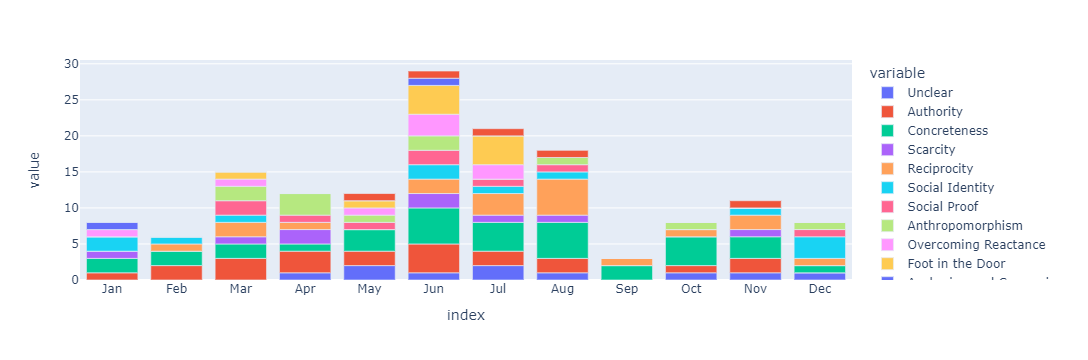

In [97]:
fig = px.bar(strategies_data['Netflix'])
fig.show()

In [81]:
import pandas as pd

all_companies_time_series = {}

for company, content in companies.items():
    time_series_data = {'Date': [], 'Time': [], 'Likes': [], 'Views': [], 'Comments': []}
    
    for video, values in content["videos"].items():
        likes = values["likeCount"]
        views = values["viewCount"]
        comments = values["commentCount"]
        date = values["publishedAt"]
        
        # Convert date to datetime
        date = pd.to_datetime(date)
        
        time_series_data['Date'].append(date.date())  # Date without time
        time_series_data['Time'].append(date.time())  # Time without date
        time_series_data['Likes'].append(likes)
        time_series_data['Views'].append(views)
        time_series_data['Comments'].append(comments)
    
    company_time_series = pd.DataFrame(time_series_data)
    company_time_series = company_time_series.sort_values(by='Date')  # Sort by date
    # company_time_series['Date'] = company_time_series['Date'].apply(lambda x: x.strftime('%b %Y'))  # Format date as "day month year"
    # company_time_series['Date'] = company_time_series['Date'].apply(lambda x: x.strftime('%Y %b %d'))
    
    # Set the 'Date' column as the index
    company_time_series.set_index('Date', inplace=True)
    
    all_companies_time_series[company] = company_time_series

In [82]:
company = '3M'
print(company)
# all_companies_time_series[company].reset_index()
# all_companies_time_series[company].sort_index(inplace=True)
all_companies_time_series[company]

3M


Time  Likes    Views  Comments
Date                                          
2015-10-12  18:25:29      4     3162         0
2016-08-04  18:22:55     45  1315218         1
2019-05-10  20:37:30     44    10523        11
2019-05-10  20:37:25     42     5718         2
2019-05-17  17:10:56      6     3788         0

In [83]:
def plot_trends(company_time_series, company_name, dynamic_window=True):
    plt.figure(figsize=(25, 6))
    
    # Calculate the simple moving average (SMA) for 'Likes', 'Views', and 'Comments'
    if dynamic_window:
        # Calculate a fraction of the total data points (adjust as needed)
        window_fraction = 0.1  # 10% of data points
        sma_window = int(len(company_time_series) * window_fraction)
        if sma_window == 0:
            sma_window = 1
        print(sma_window)
    else:
        sma_window = 30  # Fixed window size

    for metric in ['Likes', 'Comments']:
        sma = company_time_series[metric].rolling(window=sma_window).mean()
        plt.plot(company_time_series.index, sma, label=f'{metric} SMA')
        # print(sma)
        # print(company_time_series.index)
    
    plt.title(f'{company_name} - Trend Analysis')
    plt.xlabel('Year')
    plt.ylabel('Engagement')
    plt.legend()
    plt.grid(True)
    plt.show()

1


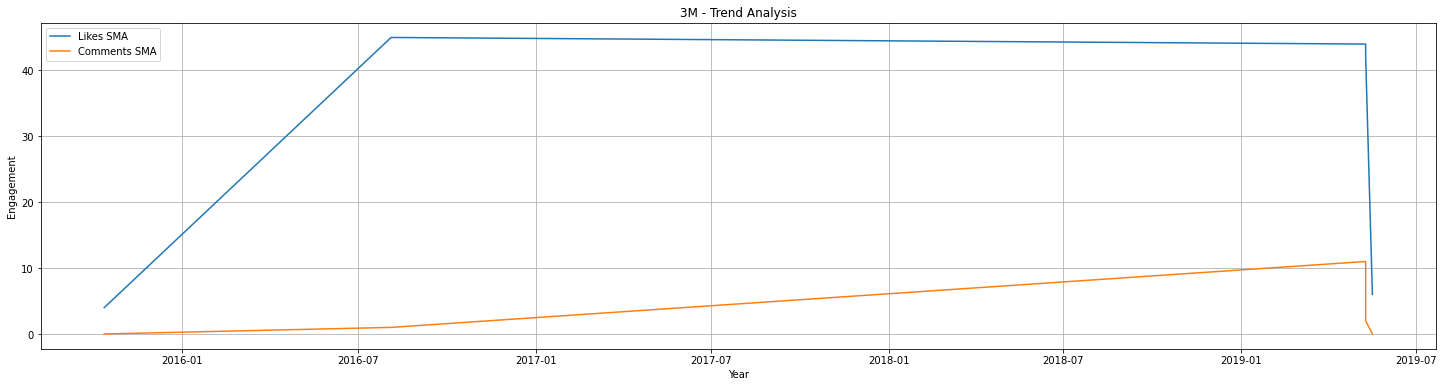

In [84]:
c = '3M'
plot_trends(all_companies_time_series[c], c)

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Define a function to perform seasonal decomposition and plot the components
def seasonal_decomposition(company_time_series, company_name):
    # Perform seasonal decomposition
    period = int(len(company_time_series)/12)
    if period == 0:
        period = int(len(company_time_series)/2)
    result = seasonal_decompose(company_time_series, model='multiplicative', period = period)

    # Plot the decomposed components
    plt.figure(figsize=(20, 8))

    plt.subplot(411)
    plt.plot(result.trend)
    plt.title('Trend')

    plt.subplot(412)
    plt.plot(result.seasonal)
    # print(result.seasonal)
    plt.title('Seasonal')

    plt.subplot(413)
    plt.plot(result.resid)
    plt.title('Residual')

    plt.subplot(414)
    plt.plot(company_time_series, label='Original')
    plt.title('Original')

    plt.suptitle(f'{company_name} - Seasonal Decomposition', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return result

67


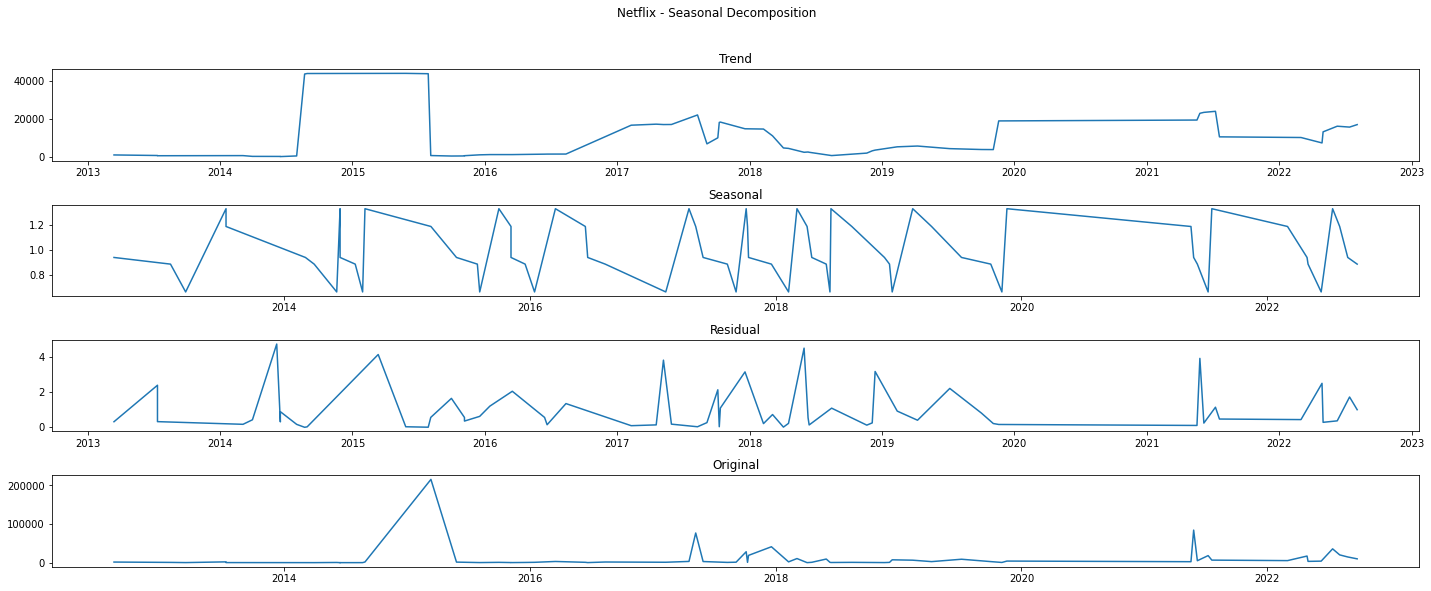

In [86]:
# c = 'Adobe Creative Cloud'
c = 'Netflix'
# c = 'NVIDIA'
# c = 'Walt Disney Studios'
# c = 'Apple'
print(len(all_companies_time_series[c]))
result = seasonal_decomposition(all_companies_time_series[c]['Likes'], c)
# plot_trends(all_companies_time_series[c], c)

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

time_index = np.arange(len(result.trend))
data_points = result.trend

# Create the Ridge Regression model
if data_points.isna().any():
    # Remove NaN values
    data_points = data_points.dropna()

# Replace infinity values with NaN
data_points = data_points.replace([np.inf, -np.inf], np.nan)

# Impute missing values with linear interpolation
data_points = data_points.interpolate()

# Re-run regression
time_index = np.arange(len(data_points))
trend_slope = np.polyfit(time_index, data_points, 1)[0]

# trend_increase = np.mean(np.diff(result.trend) > 0)
seasonal_amplitude = max(result.seasonal) - min(result.seasonal)
residual_autocorr = np.mean(np.correlate(result.resid, result.resid, 'full'))

# Mean and Standard Deviation
trend_mean = np.mean(result.trend)
seasonal_mean = np.mean(result.seasonal)
residual_mean = np.mean(result.resid)
trend_std = np.std(result.trend)
seasonal_std = np.std(result.seasonal)
residual_std = np.std(result.resid)

# Automated Insights
insights = []

# Trend Insight
if trend_slope > 100:
    trend_insight = "There is an increasing trend in Likes over the years." 
elif trend_slope < 100 and trend_slope > -100:
    trend_insight = "There is no clear trend in Likes over the years."
else:
    trend_insight = "There is a decreasing trend in Likes over the years." 

    
insights.append(trend_insight)

# Seasonal Insight
if seasonal_amplitude > 0:
    insights.append("There is a seasonal pattern with an amplitude of {:.2f}.".format(seasonal_amplitude))
else:
    insights.append("There is little to no apparent seasonal pattern.")

# Residual Insight
if abs(residual_autocorr) > 0.2:  # Example threshold, adjust as needed
    insights.append("The residuals show significant autocorrelation, indicating lingering patterns.")
else:
    insights.append("The residuals appear relatively uncorrelated, suggesting randomness.")

original_mean = np.mean(all_companies_time_series[c]['Likes'].tolist())
count = np.sum(all_companies_time_series[c]['Likes'].tolist() > original_mean*10)
insights.append(f"There are {count} peaks in the number of likes")

# Mean and Standard Deviation Insights
insights.append("The mean values: Trend = {:.2f}, Seasonal = {:.2f}, Residual = {:.2f}".format(trend_mean, seasonal_mean, residual_mean))
insights.append("The standard deviation values: Trend = {:.2f}, Seasonal = {:.2f}, Residual = {:.2f}".format(trend_std, seasonal_std, residual_std))

# Combine insights into a single message
insight = "\n".join(insights)
print("Insights:")
print(insight)

Insights:
There is an increasing trend in Likes over the years.
There is a seasonal pattern with an amplitude of 1.64.
The residuals appear relatively uncorrelated, suggesting randomness.
There are 0 peaks in the number of likes
The mean values: Trend = 20349.67, Seasonal = 0.91, Residual = 0.92
The standard deviation values: Trend = 11681.57, Seasonal = 0.70, Residual = 0.12


In [78]:
import pandas as pd

# Define the strategies
persuasions = ["Social Identity", "Concreteness", "Anchoring and Comparison", "Overcoming Reactance", "Reciprocity",
              "Foot in the Door", "Authority", "Social Impact", "Anthropomorphism", "Scarcity", "Social Proof", "Unclear"]

# Create a dictionary to store data by company and strategy
all_companies_time_series = {}

# Iterate through companies
for company, content in companies.items():
    all_companies_time_series[company] = {}  # Initialize a dictionary for the company
    
    for strategy in persuasions:
        time_series_data = {'Date': [], 'Time': [], 'Likes': [], 'Views': [], 'Comments': []}
    
        # Create a DataFrame for the company and strategy
        company_time_series = pd.DataFrame(columns=['Date', 'Time', 'Likes', 'Views', 'Comments'])
    
        # Initialize the DataFrame with data for the company and strategy
        for video, values in content["videos"].items():
            strategies = values.get("annots", [])  # Get the list of strategies for the video
            likes = values["likeCount"]
            views = values["viewCount"]
            comments = values["commentCount"]
            date = values["publishedAt"]
            
            # Check if the strategy is present in the video's annotations
            if strategy in strategies:
                # Convert date to datetime
                date = pd.to_datetime(date)
                
                time_series_data['Date'].append(date.date())  # Date without time
                time_series_data['Time'].append(date.time())  # Time without date
                time_series_data['Likes'].append(likes)
                time_series_data['Views'].append(views)
                time_series_data['Comments'].append(comments)
    
                # Append data for the video to the company_time_series DataFrame
                company_time_series = company_time_series.append({
                    'Date': date.date(),
                    'Time': date.time(),
                    'Likes': likes,
                    'Views': views,
                    'Comments': comments
                }, ignore_index=True)
        
        # Set the 'Date' column as the index
        company_time_series.set_index('Date', inplace=True)
        
        # Store the data for the company and strategy in the nested dictionary
        all_companies_time_series[company][strategy] = company_time_series

# Now you have data organized by company and strategy in the all_companies_time_series dictionary


ValueError: If using all scalar values, you must pass an index

In [77]:
c = 'Netflix'
all_data_by_strategy['Concreteness'][c]

[         Date      Time  Likes  Views  Comments
 0  2018-04-18  18:30:05    936  72775        78,
          Date      Time  Likes  Views  Comments
 0  2018-11-20  14:00:04    228  26986        85,
          Date      Time  Likes   Views  Comments
 0  2016-03-17  17:00:01   3086  214781       319,
          Date      Time  Likes   Views  Comments
 0  2018-12-13  17:00:02   7397  186154       324,
          Date      Time  Likes  Views  Comments
 0  2014-06-16  17:24:47     65   6815         2,
          Date      Time  Likes  Views  Comments
 0  2022-06-10  17:30:00   3971  56522        52,
          Date      Time  Likes   Views  Comments
 0  2017-09-05  17:17:22   1222  341472       185,
          Date      Time  Likes   Views  Comments
 0  2021-07-20  15:00:00   6585  502919       455,
          Date      Time  Likes   Views  Comments
 0  2021-05-19  12:00:00   2504  195783       129,
          Date      Time  Likes   Views  Comments
 0  2013-07-12  23:49:06   2072  294929        77

In [65]:
c = 'Netflix'
all_companies_strat_time_series['Concreteness'][c]

Time  Likes   Views  Comments
Date                                         
2012-08-13  20:24:37   1561  132727       535
2013-01-28  23:53:05    680  190782        34
2013-03-14  19:47:44    202   43001        12
2013-07-12  23:49:06   2072  294929        77
2013-07-12  23:51:53    205   31008         8
...              ...    ...     ...       ...
2022-06-10  17:30:00   3971   56522        52
2022-07-14  01:00:00  35788  763607      1317
2022-08-04  15:00:00  20161  901920       556
2022-08-28  15:28:00  14766  727804       997
2022-09-25  16:00:00   9883  300502       274

[67 rows x 4 columns]

In [64]:
c = 'Netflix'
result = seasonal_decomposition(all_companies_time_series[c]['Concreteness'], c)

KeyError: 'Concreteness'

In [47]:
def plot_trends(company_time_series, company_name, strategies_to_plot, dynamic_window=True):
    plt.figure(figsize=(25, 6))
    
    # Calculate the simple moving average (SMA) for the specified strategies
    if dynamic_window:
        # Calculate a fraction of the total data points (adjust as needed)
        window_fraction = 0.1  # 10% of data points
        sma_window = int(len(company_time_series) * window_fraction)
        if sma_window == 0:
            sma_window = 1
    else:
        sma_window = 30  # Fixed window size

    for strategy in strategies_to_plot:
        sma = company_time_series[strategy].rolling(window=sma_window).mean()
        plt.plot(company_time_series.index, sma, label=f'{strategy} SMA')
    
    plt.title(f'{company_name} - Trend Analysis')
    plt.xlabel('Year')
    plt.ylabel('Engagement')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
company_name = 'Netflix'
strategies_to_plot = ['Social Identity', 'Concreteness', 'Authority']  # Replace with your desired strategies

# Assuming you have company_time_series data for the sample
# company_time_series = all_companies_strat_time_series[company_name]

# Call the plot_trends function
plot_trends(company_time_series, company_name, strategies_to_plot, dynamic_window=True)

KeyError: 'Social Identity'

<Figure size 1800x432 with 0 Axes>

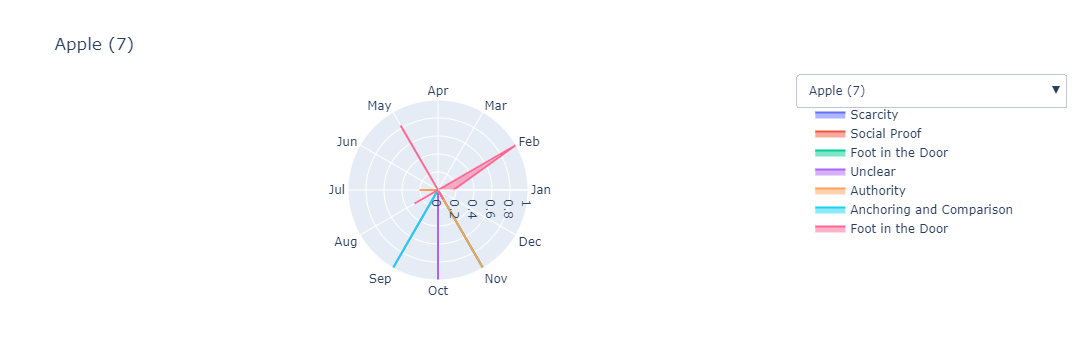

In [246]:
import plotly.graph_objects as go
from datetime import datetime
import numpy as np

polar_graphs = []
num_companies = len(companies)
plot_dicts = []
top_5_polar_plots = []
j = 0

# Initialize a dictionary to store data by strategy and month

angles = [i * (360 / len(months)) for i in range(len(months))]

for company, content in companies.items():
    data_by_strategy_and_month = {}
    company_views = {}
    company_likes = {}
    company_comments = {}
    video_frequency = {}

    for pers in persuasions:
        company_views[pers] = 0
        company_likes[pers] = 0
        video_frequency[pers] = 0

    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likes = values["likeCount"]
        date = values["publishedAt"]
        month = datetime.strptime(date, "%Y-%m-%dT%H:%M:%SZ").month

        for strat in strats:
            if strat not in data_by_strategy_and_month:
                data_by_strategy_and_month[strat] = {month: 0 for month in range(1, 13)}
            
            data_by_strategy_and_month[strat][month] += likes

    strat_names = list(data_by_strategy_and_month.keys())

    if j == 0:
        visible_action = True
    else:
        visible_action = False

    # Create traces for each strategy
    traces = []

    for strat in strat_names:
        likes_for_strat = [data_by_strategy_and_month[strat][month] for month in range(1, 13)]

        # Normalize the values between 0 and 1
        max_likes = max(likes_for_strat)
        if max_likes != 0:
            likes_for_strat = [x / max_likes for x in likes_for_strat]

        trace = go.Scatterpolar(
            r=likes_for_strat,
            theta=angles,
            mode='lines',
            fill='toself',  # Fill area with color
            name=f"{strat}",
            visible=visible_action
        )

        traces.append(trace)

    polar_graphs.extend(traces)

    if company in top_5_company_names:
        top_5_polar_plots.extend(traces[-len(strat_names):])

    visibility = [False] * num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}],
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j += 1

fig = go.Figure(data=polar_graphs)

fig.update_layout(
    polar=dict(
        angularaxis=dict(
            tickmode='array',
            tickvals=angles,
            ticktext=months
        ),
        radialaxis=dict(
            range=[0, 1]
            # range=[0, max_likes]
        )
    )
)

fig.update_layout(
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig.show()


#### Sector

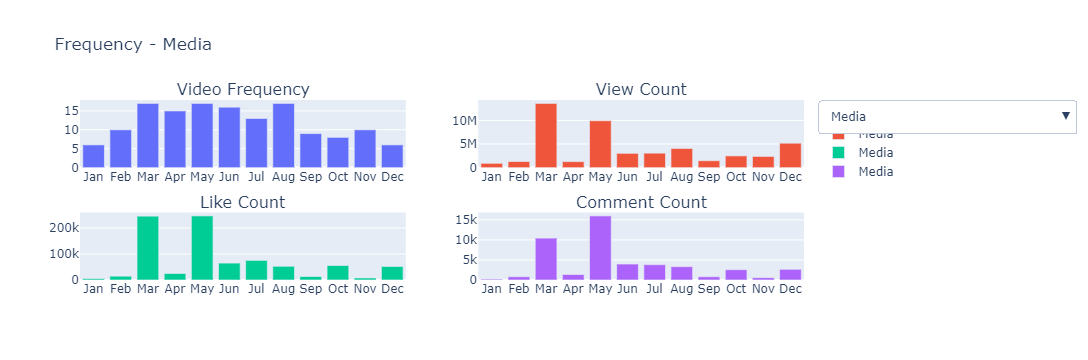

In [221]:
import plotly.graph_objs as go
from datetime import datetime
import plotly.subplots as sp
import itertools

# Initialize variables for four figures
figs = sp.make_subplots(rows=2, cols=2, subplot_titles=( "Video Frequency", "View Count", "Like Count", "Comment Count"))
num_sectors = len(sectors)

metrics = ["frequency", "viewCount", "likeCount", "commentCount"]

# Create a list of sectors
sector_list = list(sectors.keys())

# Initialize visibility list for metrics
initial_visibility = [False] * num_sectors

# Set the initial sector to be visible
initial_visibility[0] = True

# Create traces for each metric
for i, metric in enumerate(metrics):
    metric_data = []

    for sector, values in sectors.items():
        sector_metric_total = [0] * len(months)

        for video, content in values["videos"].items():
            if metric == "frequency":
                metric_value = 1
            else:
                metric_value = content[metric]
            date = datetime.strptime(content["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
            month = date.strftime("%b")

            sector_metric_total[months.index(month)] += metric_value

        metric_data.append(go.Bar(
            x=months,
            y=sector_metric_total,
            name=sector,
            visible=initial_visibility[sector_list.index(sector)],  # Set initial visibility
        ))

    row = i // 2 + 1
    col = i % 2 + 1
    for trace in metric_data:
        figs.add_trace(trace, row=row, col=col)

# Create buttons for sector selection
buttons = [
    dict(label=sector, method="update", args=[{"visible": [sector == s for s in sector_list]}, {"title": f"{metric.capitalize()} - {sector}"}])
    for sector, metric in itertools.product(sector_list, metrics)
]

# Add buttons to update the visibility based on selected sector
figs.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.02,
            xanchor="left",
            y=1,
            yanchor="top"
        ),
    ],
    barmode='group',
    title=f"{metrics[0].capitalize()} - {sector_list[0]}",
)

figs.show()

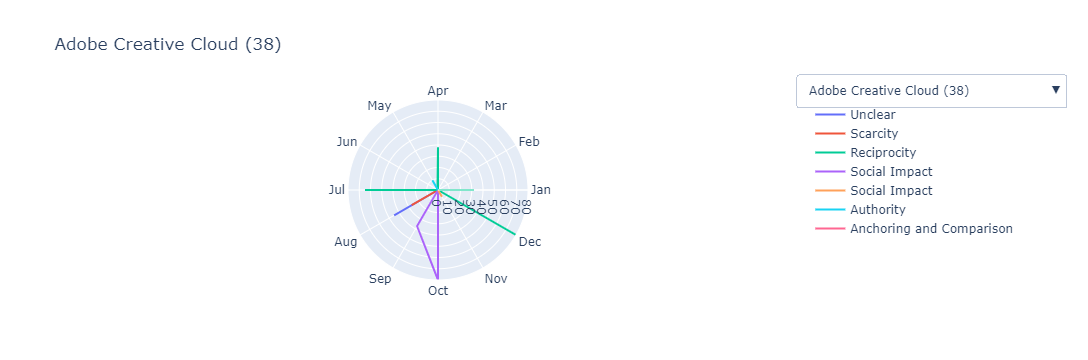

In [251]:
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import itertools

polar_graphs = []
num_companies = len(companies)
plot_dicts = []
j = 0

# Initialize a dictionary to store data by strategy, year, and month
data_by_strategy_year_and_month = {}

angles = [i * (360 / len(months)) for i in range(len(months))]

for company, content in companies.items():
    data_by_strategy_year_and_month = {}
    for video, values in content["videos"].items():
        strats = values["annots"]
        likes = values["likeCount"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        year = date.year
        month = date.month

        for strat in strats:
            if strat not in data_by_strategy_year_and_month:
                data_by_strategy_year_and_month[strat] = {}

            if year not in data_by_strategy_year_and_month[strat]:
                data_by_strategy_year_and_month[strat][year] = {month: 0 for month in range(1, 13)}

            data_by_strategy_year_and_month[strat][year][month] += likes

    strat_names = list(data_by_strategy_year_and_month.keys())
    max_likes = max(max(max(month_data.values()) for month_data in year_data.values()) for year_data in data_by_strategy_year_and_month.values())

    if j == 0:
        visible_action = True
    else:
        visible_action = False

    # Create traces for each strategy
    traces = []

    for strat in strat_names:
        years = list(data_by_strategy_year_and_month[strat].keys())
        years.sort()  # Sort the years

        # Create a list of months for the x-axis
        months_list = []
        for year in years:
            months_list.extend(data_by_strategy_year_and_month[strat][year].keys())
        months_list = sorted(list(set(months_list)))

        # Create a list of video frequencies for each month
        freq_for_strat = [data_by_strategy_year_and_month[strat][year][month] if month in data_by_strategy_year_and_month[strat][year] else 0
                           for year, month in itertools.product(years, months_list)]

        trace = go.Scatterpolar(
            r=freq_for_strat,
            theta=angles * len(years),  # Repeat angles for each year
            mode='lines',
            name=f"{strat}",
            visible=visible_action
        )

        traces.append(trace)

    polar_graphs.extend(traces)

    visibility = [False] * num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}],
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j += 1

fig = go.Figure(data=polar_graphs)

fig.update_layout(
    polar=dict(
        angularaxis=dict(
            tickmode='array',
            tickvals=angles,
            ticktext=months
        ),
        radialaxis=dict(
            range=[0, max_likes]  # Set the range for the radial axis to max_likes
        )
    )
)

fig.update_layout(
    updatemenus=[dict(buttons=plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)

fig.show()


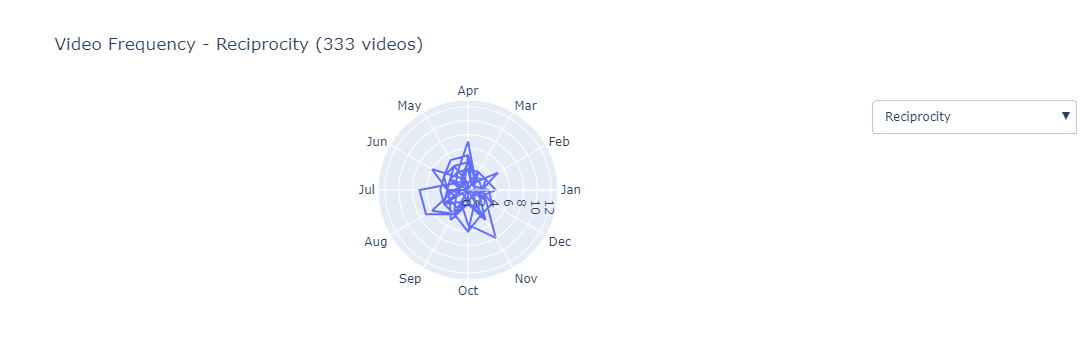

In [248]:
import plotly.graph_objects as go
from datetime import datetime
import numpy as np

strat_counts = {strat: 0 for strat in strat_names}

# Initialize a dictionary to store data by strategy, year, and month
data_by_strategy_year_and_month = {}

angles = [i * (360 / len(months)) for i in range(len(months))]

# Create a list to store traces for each strategy
traces = []

# Initialize maximum frequency
max_frequency = 0

for company, content in companies.items():
    for video, values in content["videos"].items():
        strats = values["annots"]
        date = datetime.strptime(values["publishedAt"], "%Y-%m-%dT%H:%M:%SZ")
        year = date.year
        month = date.month

        for strat in strats:
            if strat not in data_by_strategy_year_and_month:
                data_by_strategy_year_and_month[strat] = {}

            if year not in data_by_strategy_year_and_month[strat]:
                data_by_strategy_year_and_month[strat][year] = {month: 0 for month in range(1, 13)}

            data_by_strategy_year_and_month[strat][year][month] += 1  # Increment by 1 for video frequency

            strat_counts[strat] += 1
            
            # Update maximum frequency
            max_frequency = max(max_frequency, data_by_strategy_year_and_month[strat][year][month])

# Create buttons for strategy selection
buttons = [
    dict(label=strat, method="update", args=[{"visible": [strat == s for s in strat_names]}, {"title": f"Video Frequency - {strat} ({strat_counts[strat]} videos)"}])
    for strat in strat_names
]

# Initialize visibility list for strategies
initial_visibility = [False] * len(strat_names)

# Set the initial strategy to be visible
initial_visibility[0] = True

# Create traces for each strategy
for strat in strat_names:
    years = list(data_by_strategy_year_and_month[strat].keys())
    years.sort()  # Sort the years

    # Create a list of months for the x-axis
    months_list = []
    for year in years:
        months_list.extend(data_by_strategy_year_and_month[strat][year].keys())
    months_list = sorted(list(set(months_list)))

    # Create a list of video frequencies for each month
    freq_for_strat = [data_by_strategy_year_and_month[strat][year][month] if month in data_by_strategy_year_and_month[strat][year] else 0
                       for year, month in itertools.product(years, months_list)]

    trace = go.Scatterpolar(
        r=freq_for_strat,
        theta=angles * len(years),  # Repeat angles for each year
        mode='lines',
        name=strat,
        visible=initial_visibility[strat_names.index(strat)],  # Set initial visibility
    )

    traces.append(trace)

fig = go.Figure(data=traces)

fig.update_layout(
    polar=dict(
        angularaxis=dict(
            tickmode='array',
            tickvals=angles,
            ticktext=months
        ),
        radialaxis=dict(
            range=[0, max_frequency + 1]  # Set the range for the radial axis based on the maximum frequency
        )
    )
)

# Add buttons to update the visibility based on selected strategy
fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.02,
            xanchor="left",
            y=1,
            yanchor="top"
        ),
    ],
    title=f"{strat_names[0]} ({strat_counts[strat_names[0]]} videos)",
)

fig.show()